# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier #решающее дерево
from sklearn.ensemble import RandomForestClassifier #случайный лес
from sklearn.linear_model import LogisticRegression #логистическая регрессия

from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
display(df.shape)
display(df.info())
display(df.head(10))

(3214, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Это задача классификации. 

Целевым признаком является столбец is_ultra. 

Остальные признаки помогут предсказывать решение по столбцу is_ultra.

Данных я думаю среднее количество, посмотрим как себя покажет модель на тестовых данных.

<AxesSubplot:>

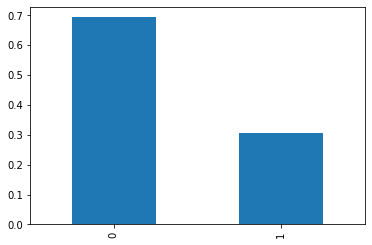

In [3]:
class_frequency = df['is_ultra'].value_counts(normalize = True)
class_frequency.plot(kind = 'bar')

<div class="alert alert-info">
    
Проверила датасет на сбалансированность таргетов. Отрицательного класса значительно больше, чем положительного.
    
В train_test_split изменила stratify при сплитировании (он позволит сохранить изначальное распределение таргетов во всех новых датасетах.)
</div>

## Разобьем данные на выборки

Сначалa поделим на features и target

In [4]:
features = df.drop(['is_ultra'], axis = 1)
target = df['is_ultra']

<b>Разделим исходные данные на обучающую, валидационную и тестовую выборки.

Сначала разделим на обучающую выборку и и остальное в соотношении 60% на 40%, 

затем остальное поделим на тестовую и валидационную в соотношении 50% на 50%, так как нужно получить по 20%


In [5]:
features_train, features_other, target_train, target_other = train_test_split(features, target, train_size=0.6, random_state = 12345, stratify =target)
features_valid, features_test, target_valid, target_test = train_test_split(features_other, target_other, test_size=0.5, random_state = 12345, stratify =target_other)
#последнюю делим пополам по 20% от исходных данных
#обучающая - 60% от исходной
print('Размер обучающей выборки', features_train.shape[0])
print('Размер валидационной выборки', features_valid.shape[0])
print('Размер тестовой выборки', features_test.shape[0])

Размер обучающей выборки 1928
Размер валидационной выборки 643
Размер тестовой выборки 643


## Исследуем модели

### Решающее дерево

Сначала посмотрим какая глубина дерева лучше.

In [6]:
best_model1 = None
best_result = 0
best_depth = 0
for depth in range(1,11):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth, criterion = 'gini')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result>best_result:
        best_model1 = model
        best_result = result
        best_depth = depth
        
print('accuracy_score =', best_result, 'depth =', best_depth)

accuracy_score = 0.80248833592535 depth = 8


Теперь посмотрим какой критерий лучше.

In [7]:
best_model1 = None
best_result = 0
best_depth = 0
best_criterion = ''
for crit in ('entropy','gini'):
    for depth in range(1,11):
        model = DecisionTreeClassifier(random_state = 12345, max_depth = depth, criterion = crit)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result>best_result:
            best_model1 = model
            best_result = result
            best_depth = depth
            best_criterion = crit
        
print('accuracy_score =',best_result, 'depth =', best_depth, 'criterion =',best_criterion )

accuracy_score = 0.80248833592535 depth = 8 criterion = gini


Получается, что в данном случае параметр criterion никак не влияет на точность.

Изменим splitter с best на random.

In [8]:
model = DecisionTreeClassifier(random_state=12345, max_depth=8, splitter = 'random')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('depth=', 8,'accuracy_score=',result)

depth= 8 accuracy_score= 0.7713841368584758


Splitter best точнее, чем random.

<b>Теперь найдем лучший вариант из всех:


In [9]:
best_model1 = None
best_result = 0
best_depth = 0
best_features = 0
best_splitter = 0
for spl in ('best','random'):
    for feats in ('sqrt', 'log2', None):
        for depth in range(1,11):
            model = DecisionTreeClassifier(random_state = 12345, max_depth = depth,  \
                                           splitter = spl, max_features = feats)
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions_valid)
            if result>best_result:
                best_model1 = model
                best_result = result
                best_depth = depth
                best_splitter = spl
                best_features = feats
        
print('accuracy_score =',best_result)
print( 'depth =', best_depth)
print('splitter =',best_splitter)
print('max_features =', best_features)

accuracy_score = 0.80248833592535
depth = 8
splitter = best
max_features = None


Точность повысилась, и глубина дерева выросла до 8. 

### Исследуем с помощью GridSearch

<div class="alert alert-warning">


В случае использования GridSearch, не нужно будет заранее делать валидационную выборку, лучшую метрику автоматом сохранят в best_score_, а лучшую модель (переобученная уже на полном наборе данных) будет хранить в best_estimator_. 
 
</div>


In [10]:
from sklearn.model_selection import GridSearchCV

classifier = DecisionTreeClassifier(random_state = 12345)
parameters_grid = {
        'splitter' : ['best','random'],
        'max_features' : ['sqrt', 'log2', None],
        'max_depth' : range(1,11)
   }
f_train, f_test, t_train, t_test = train_test_split(features, target, train_size=0.6, random_state = 12345, stratify =target)

In [11]:
grid = GridSearchCV(classifier, parameters_grid, cv=5)
#grid.fit(f_train, t_train)
grid.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 11),
                         'max_features': ['sqrt', 'log2', None],
                         'splitter': ['best', 'random']})

In [12]:
grid.best_params_

{'max_depth': 6, 'max_features': None, 'splitter': 'best'}

In [13]:
grid.score(f_train, t_train)

0.8283195020746889

### Случайный лес

Сначала посмотрим сколько понадобится деревьев для лучшей точности.

In [14]:
best_model2 = None
best_result = 0

best_est = 0
for est in range(10,51,1):
    model = RandomForestClassifier(random_state = 12345,n_estimators = est)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result>best_result:
        best_model2 = model
        best_result = result
        best_est = est
    
        
print('accuracy_score =',round(best_result, 5), 'n_estimators = ', best_est)

accuracy_score = 0.8056 n_estimators =  48


Теперь добавим переменную глубины.

In [15]:
%%time

best_model2 = None
best_result = 0
best_depth = 0
best_est = 0
for est in range(10,51,1):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state = 12345,n_estimators = est, max_depth = depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        #result = model.score(predictions_valid, target_valid)
        if result>best_result:
            best_model2 = model
            best_result = result
            best_est = est
            best_depth = depth
        
print('accuracy_score =', best_result, 'n_estimators = ', best_est, 'depth =', best_depth)

accuracy_score = 0.8227060653188181 n_estimators =  39 depth = 9
CPU times: user 39.8 s, sys: 205 ms, total: 40 s
Wall time: 40.5 s


Точность увеличилась, деревьев теперь нужно больше - 40, глубиной 8.

Но! данный перебор считается достаточно долго, что не есть хорошо.

Поменяем criterion на entropy

In [16]:
model = RandomForestClassifier(random_state=12345, max_depth = 8,n_estimators = 40, criterion="entropy")
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('accuracy_score =', result, 'n_estimators = ', 40, 'depth =', 8)

accuracy_score = 0.8164852255054432 n_estimators =  40 depth = 8


Точность у entropy хуже.

посмотрим влияние max_features (число признаков для выбора расщепления)

In [17]:
%%time

best_model2 = None
best_result = 0
best_features = 0

for feats in ('sqrt', 'log2', None):
    model = RandomForestClassifier(random_state = 12345,n_estimators = 27, max_depth=10, max_features = feats )
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    #result = model.score(predictions_valid, target_valid)
    print('accuracy = ', result, 'max_features =', feats)
    if result>best_result:
        best_model2 = model
        best_result = result
        best_features = feats
    
        
print('accuracy_score =', best_result, 'max_features = ', best_features)

accuracy =  0.8118195956454122 max_features = sqrt
accuracy =  0.8118195956454122 max_features = log2
accuracy =  0.8087091757387247 max_features = None
accuracy_score = 0.8118195956454122 max_features =  sqrt
CPU times: user 381 ms, sys: 3.86 ms, total: 385 ms
Wall time: 405 ms


Значит параметр mаx_features влияет на точность только при None.

<b>Теперь найдем лучший вариант из всех:


In [18]:
%%time

model_RFC = None
best_result = 0
best_depth = 0
best_criterion = 0
best_n_estimators = 0
best_bootstrap = 0
for crit in ('entropy','gini'):
    for est in range(10,51,5):
        for bst in (True, False):
            for depth in range(1,11):
                model = RandomForestClassifier(random_state = 12345, max_depth = depth, criterion = crit, \
                                               n_estimators = est, bootstrap = bst)
                model.fit(features_train, target_train)
                predictions_valid = model.predict(features_valid)
                result = accuracy_score(target_valid, predictions_valid)
                if result>best_result:
                    model_RFC = model
                    best_result = result
                    best_depth = depth
                    best_criterion = crit
                    best_n_estimators = est
                    best_bootstrap = bst
        
print('accuracy_score =',best_result)
print( 'depth =', best_depth)
print('criterion =',best_criterion )
print('n_estimators =',best_n_estimators)
print('bootstrap =', best_bootstrap)

accuracy_score = 0.8211508553654744
depth = 9
criterion = gini
n_estimators = 40
bootstrap = True
CPU times: user 34.6 s, sys: 145 ms, total: 34.8 s
Wall time: 34.9 s


### Логистическая регрессия

Сначала будем менять выбор solver'а.

In [19]:
best_solver = ''
best_result = 0

for solv in {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}:
    model = LogisticRegression(random_state = 12345, solver=solv)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    print('solver', solv, 'accuracy ', result)
    if result>best_result:
        best_model3 = model
        best_result = result          
        best_solver= solv

print()
print('solver =', best_solver,'accuracy_score =', best_result) 

solver lbfgs accuracy  0.7387247278382582
solver sag accuracy  0.6936236391912908
solver newton-cg accuracy  0.7387247278382582
solver liblinear accuracy  0.71850699844479
solver saga accuracy  0.6936236391912908

solver = lbfgs accuracy_score = 0.7387247278382582


Выбрав лучший solver 'newton-cg' поменяем количество итерации.

In [20]:
best_model3 = None
best_result = 0
best_iter = 0

for iterr in range(10,101,10):
    model = LogisticRegression(random_state = 12345,solver = 'newton-cg', max_iter = iterr)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result>best_result:
        best_model3 = model
        best_result = result
        best_iter = iterr            
        
        
print('accuracy_score =',best_result, 'max_iter = ', best_iter)

accuracy_score = 0.7387247278382582 max_iter =  50


<b>Решающее дерево : </b>

accuracy_score = 0.80248833592535
depth = 8
splitter = best
max_features = None

<b>Случайный лес: </b>

accuracy_score = 0.8211508553654744
depth = 9
criterion = gini
n_estimators = 40
bootstrap = True

<b>Логистическая регрессия:</b>

accuracy_score = 0.7387247278382582 
max_iter =  50 
solver = newton-cg

# Таким образом, лучше всех себя показала модель случайного леса.

Для проверки модели на тестовых данных выбираем ее.

<div class="alert alert-success">
    
У логистической регрессии есть и другие гиперпараметры, но логистическая регрессия все равно окажется худшей. 
    
Логистическая регрессия это линейный классификатор: обьекты делим гиперплоскостью (прямой если на плоскости), а в данном датасете видимо более сложные, нелинейные связи между признаками и таргетом. А RF с DT с этим справляются. На других данных  LR могла оказаться лучше, например потому что RF не может экстраполировать. 


</div>

## Проверьте модель на тестовой выборке

### Случайный лес

<div class="alert alert-warning">


Совет как можно улучшить результат, не особо мучаясь с кодом:
    
Смотри - мы сформировали train выборку на которой обучаем модель, а валидационную используем для поиска лучших значений гиперпараметров. Отлично, нашли их. Так почему бы теперь модель с выбранными гиперпараметрами не обучить на тренировочной + валидационной выборке?! Чем больше данных, тем лучше модель может обучиться. И эту дообученную модель проверим на тесте. Гаранитий что станет лучше нет, но ML это постоянные эксперименты.



</div>

Сначала создадим новую обучающую выборку, объединив исходные обучающую и валидационную.

In [21]:
features_new_train = pd.concat([features_train] + [features_valid])
target_new_train = pd.concat([target_train] + [target_valid])
print(features_new_train.shape)
print(target_new_train.shape)
features_new_train, target_new_train = shuffle(features_new_train, target_new_train)

(2571, 4)
(2571,)


Теперь переобучим модель на этих данных и получим accuracy на тестовых данных.

In [22]:
model_RFC = RandomForestClassifier(random_state = 12345, max_depth = 9, criterion = 'gini', \
                                              n_estimators = 40, bootstrap = True)
model_RFC.fit(features_new_train, target_new_train)
predictions_test = model_RFC.predict(features_test)
result_RFC = accuracy_score(target_test, predictions_test)
print("Качество:", result_RFC)

Качество: 0.8164852255054432


Качество тестовой выбоки получилось даже немного лучше, чем когда обучали на исходной обучающей выборке! победа!

<b>ИТОГ:</b>

Для решения поставленной задачи можно выбрать модель случайного леса со значением точности почти 0.82.

Учитывая разницу между текущей точностью и точностью на валидационной выборке, можно сказать, что модель обучена хорошо. 

На валидационной выборке acc: 0.8087091757387247 

На тестовой выборке acc:      0.7962674961119751

## (бонус) Проверьте модели на адекватность

Оценить адекватность модели можно используя данные метрики:

* accuracy - точность совпадения прогнозов с правильными ответами.
* precision - отношение правильно предсказанных классов к сумме правильно предсказанных классов с неправильными предсказаниями.
* recall - отношение правильно предсказанных классов к сумме правильно предсказанных классов с неправильными предсказаниями.
* F-мера - среднее гармоническое между precision и recall. Если хотя бы один из параметров близок к нулю, то и F-мера стремится к 0. Если оба стремятся к 1, то F-мера тоже стремится к 1.

In [23]:
def metricss(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))

In [24]:
metricss(target_test, predictions_test)

Полнота 0.5329949238578681
Точность 0.8015267175572519
F1-мера 0.6402439024390244


Посмотрим какое распределение было:

<AxesSubplot:>

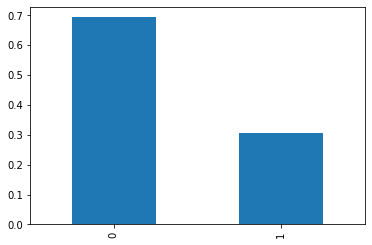

In [25]:
class_frequency = df['is_ultra'].value_counts(normalize = True)
class_frequency.plot(kind = 'bar')

И также сделаем анализ частот классов в результате предсказания нашей модели случайного леса.

<AxesSubplot:>

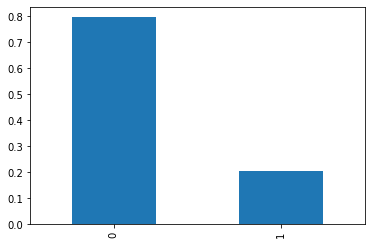

In [26]:
predicted_test = pd.Series(predictions_test)
class_frequency_2 = predicted_test.value_counts(normalize = True)
class_frequency_2.plot(kind = 'bar')

Создадим константную модель и сравним с ней.

In [27]:
target_pred_constant = pd.Series(data = 0, index = target.index)
print(accuracy_score(target, target_pred_constant))

0.693528313627878


0,82>0.69, значит наша модель адекватная.

<div class="alert alert-success">
    
Константная модель тупо предсказывает самый частый класс, его могло быть 99%, и тогда точность была 99%, но это ничего не говорит о качестве константной модели, просто дисбаланс в таргетах такой. Константная модель это минимум, и если наша модель даже не побила наивный прогноз, то значит что то не то с нашей моделью. 
    
</div>

Однако наша модель получила значение 0.82, что значительно выше. 
Я бы сказала модель относительно адекватная, однако стоит привлечь способы работы с несбалансированной классификацией, а именно:

- взвешивание классов
- upsampling
- downsampling

<div class="alert alert-success">

С   DummyClassifier это выглядело бы  так:
    
    dс = DummyClassifier(strategy='most_frequent', random_state=RSEED)
    dс.fit(features_train, target_train)
    acc = dс.score(features_test, target_test)

acc - Качество наивного прогноза (те же 0,69)
'most_frequent' - это стратегия предсказывания самого частого класса в target_train    
    
    
    
    
    upsampling
    downsampling
    
</div>

## Итоговый вывод

<b>В ходе проделанной работы было выполнено:

* Изучен файл с данными.
* Разбиты данные на три выборки: обучающая, валидационная и тестовая.
* Исследованы три модели классификации: Решающее дерево, Случайный лес и Логистическая регрессия.
* С помощью перебора найдены оптимальные параметры для каждой модели и выбрана последняя для обучения модели.
* Оценена точность обученных моделей на тестовой выборке.
* Оценена адекватность моделей.
* Для обучения модели было использована выборка почти в 2000 (1928) значений. Этого может быть недостаточно для повышения главных метрик качества модели классификатора. При увеличении выборки, должны повысится accuracy, precision и recall, но в тоже время повысится и время на поиск оптимальных параметров и обучение.
* Адекватность модели повышается с ростом количества значений.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75


In [1]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei